### paths

In [5]:
import os
import sys
import numpy as np

proj_base_path = '../../../'
data_base_path = '../../../datasets'
models_base_path = '../../../pretrained_models'
sys.path.append(os.path.join(os.getcwd(), proj_base_path))

dataset_path = 'numpy/pokemon_clustered_time_no_transp/meta/'
word_vectors_file = '_word_vectors_5000_ignore_ratio=0.05.wv'
duration_dict_file = 'durations_dict.json'

word_vectors_path = os.path.join(data_base_path, dataset_path, word_vectors_file)
duration_dict_path = os.path.join(data_base_path, dataset_path, duration_dict_file)

### loading embedding

In [6]:
from gensim.models import KeyedVectors

wv = KeyedVectors.load(word_vectors_path, mmap='r')

In [7]:
import json

with open(duration_dict_path) as fp:
    duration_dict = json.load(fp)

### loading model

In [9]:
from tensorflow import keras as K

model_dir = 'lstm_clustered_time_pls1_/embedded_clustered_time_64_no_transp/'
model_file = 'model_last_cpu.h5'
model = K.models.load_model(os.path.join(models_base_path, model_dir, model_file))

### creating output dir

In [10]:
output_dir = os.path.join(models_base_path, model_dir, 'samples')
os.makedirs(output_dir, exist_ok=True)

print(f'saving samples to {output_dir}')

saving samples to ../../../pretrained_models/lstm_clustered_time_pls1_/embedded_clustered_time_64_no_transp/samples


### importing and preparing seed generators

In [11]:
from src.generating.embedded_clustered_time_generating_seeds import get_seed_generators

seed_generators = get_seed_generators(duration_dict, ignore_shortest=True)

seed_gens = [
    ('random_noise_seed', lambda length, input_size, wv, batch_size: seed_generators['random_noise_seed'](
        length, input_size, batch_size=batch_size)),
    ('zero_seed', lambda length, input_size, wv, batch_size: seed_generators['zero_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('const_frame_seed', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    
    ('const_frame_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['const_frame_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
    ('multi_note_harmonic_seed_noise', lambda length, input_size, wv, batch_size: seed_generators['multi_note_harmonic_seed_noise'](
        length, input_size, word_vectors=wv, batch_size=batch_size)),
]

### defining generating constants

In [12]:
from src.data_processing.common.rw_np_mid import read_numpy_midi, save_numpy_midi
from src.generating.generating import recurrent_generate
from src.data_processing.sparse_notes_classified_time.np2mid import np2sparse, np2mid
from src.data_processing.sparse_notes_classified_time.embed_adapt import decode_note_vector_track
import matplotlib.pyplot as plt
from time import time
from datetime import datetime

In [71]:
SEED_LENGTH = 5
SEQ_LENGTH = 200
INPUT_SIZE = 16
WINDOW_SIZE = 50
BATCH_SIZE = 4

In [111]:
def adjust_duration(x):
    res = np.zeros_like(x)
    res[np.argmax(x)] = 1
    return res

def adjust_notes(x):
    return wv[wv.similar_by_vector(x, topn=1)[0][0]]

def adjust_duration_batch(batch):
    return np.array([[adjust_duration(f) for f in sample] for sample in batch])

def adjust_notes_batch(batch):
    return np.array([[adjust_notes(f) for f in sample] for sample in batch])


seed_per_gen = [gen(SEED_LENGTH, INPUT_SIZE, wv, BATCH_SIZE) for _, gen in [seed_gens[2]]]
samples_per_gen = [
    recurrent_generate(
        model,
        seed,
        SEQ_LENGTH,
        WINDOW_SIZE,
        is_binary=False,
        transform_input=lambda x: (x[:, :, :INPUT_SIZE], x[:, :, INPUT_SIZE:]),
        transform_output=lambda args: np.concatenate((adjust_notes_batch(args[0]), adjust_duration_batch(args[1])), axis=2),
    ) for seed in seed_per_gen
]

In [112]:
sparse_samples_per_gen = [[
    np2sparse(
        decode_note_vector_track(s[:, :INPUT_SIZE], wv, return_similarities=False),
        s[:, INPUT_SIZE:],
        duration_dict,
        ppq=20,
    ) for s in samples
] for samples in samples_per_gen]

midis_per_gen = [[
    np2mid(
        decode_note_vector_track(s[:, :INPUT_SIZE], wv, return_similarities=False),
        s[:, INPUT_SIZE:],
        duration_dict,
    ) for s in samples
] for samples in samples_per_gen]

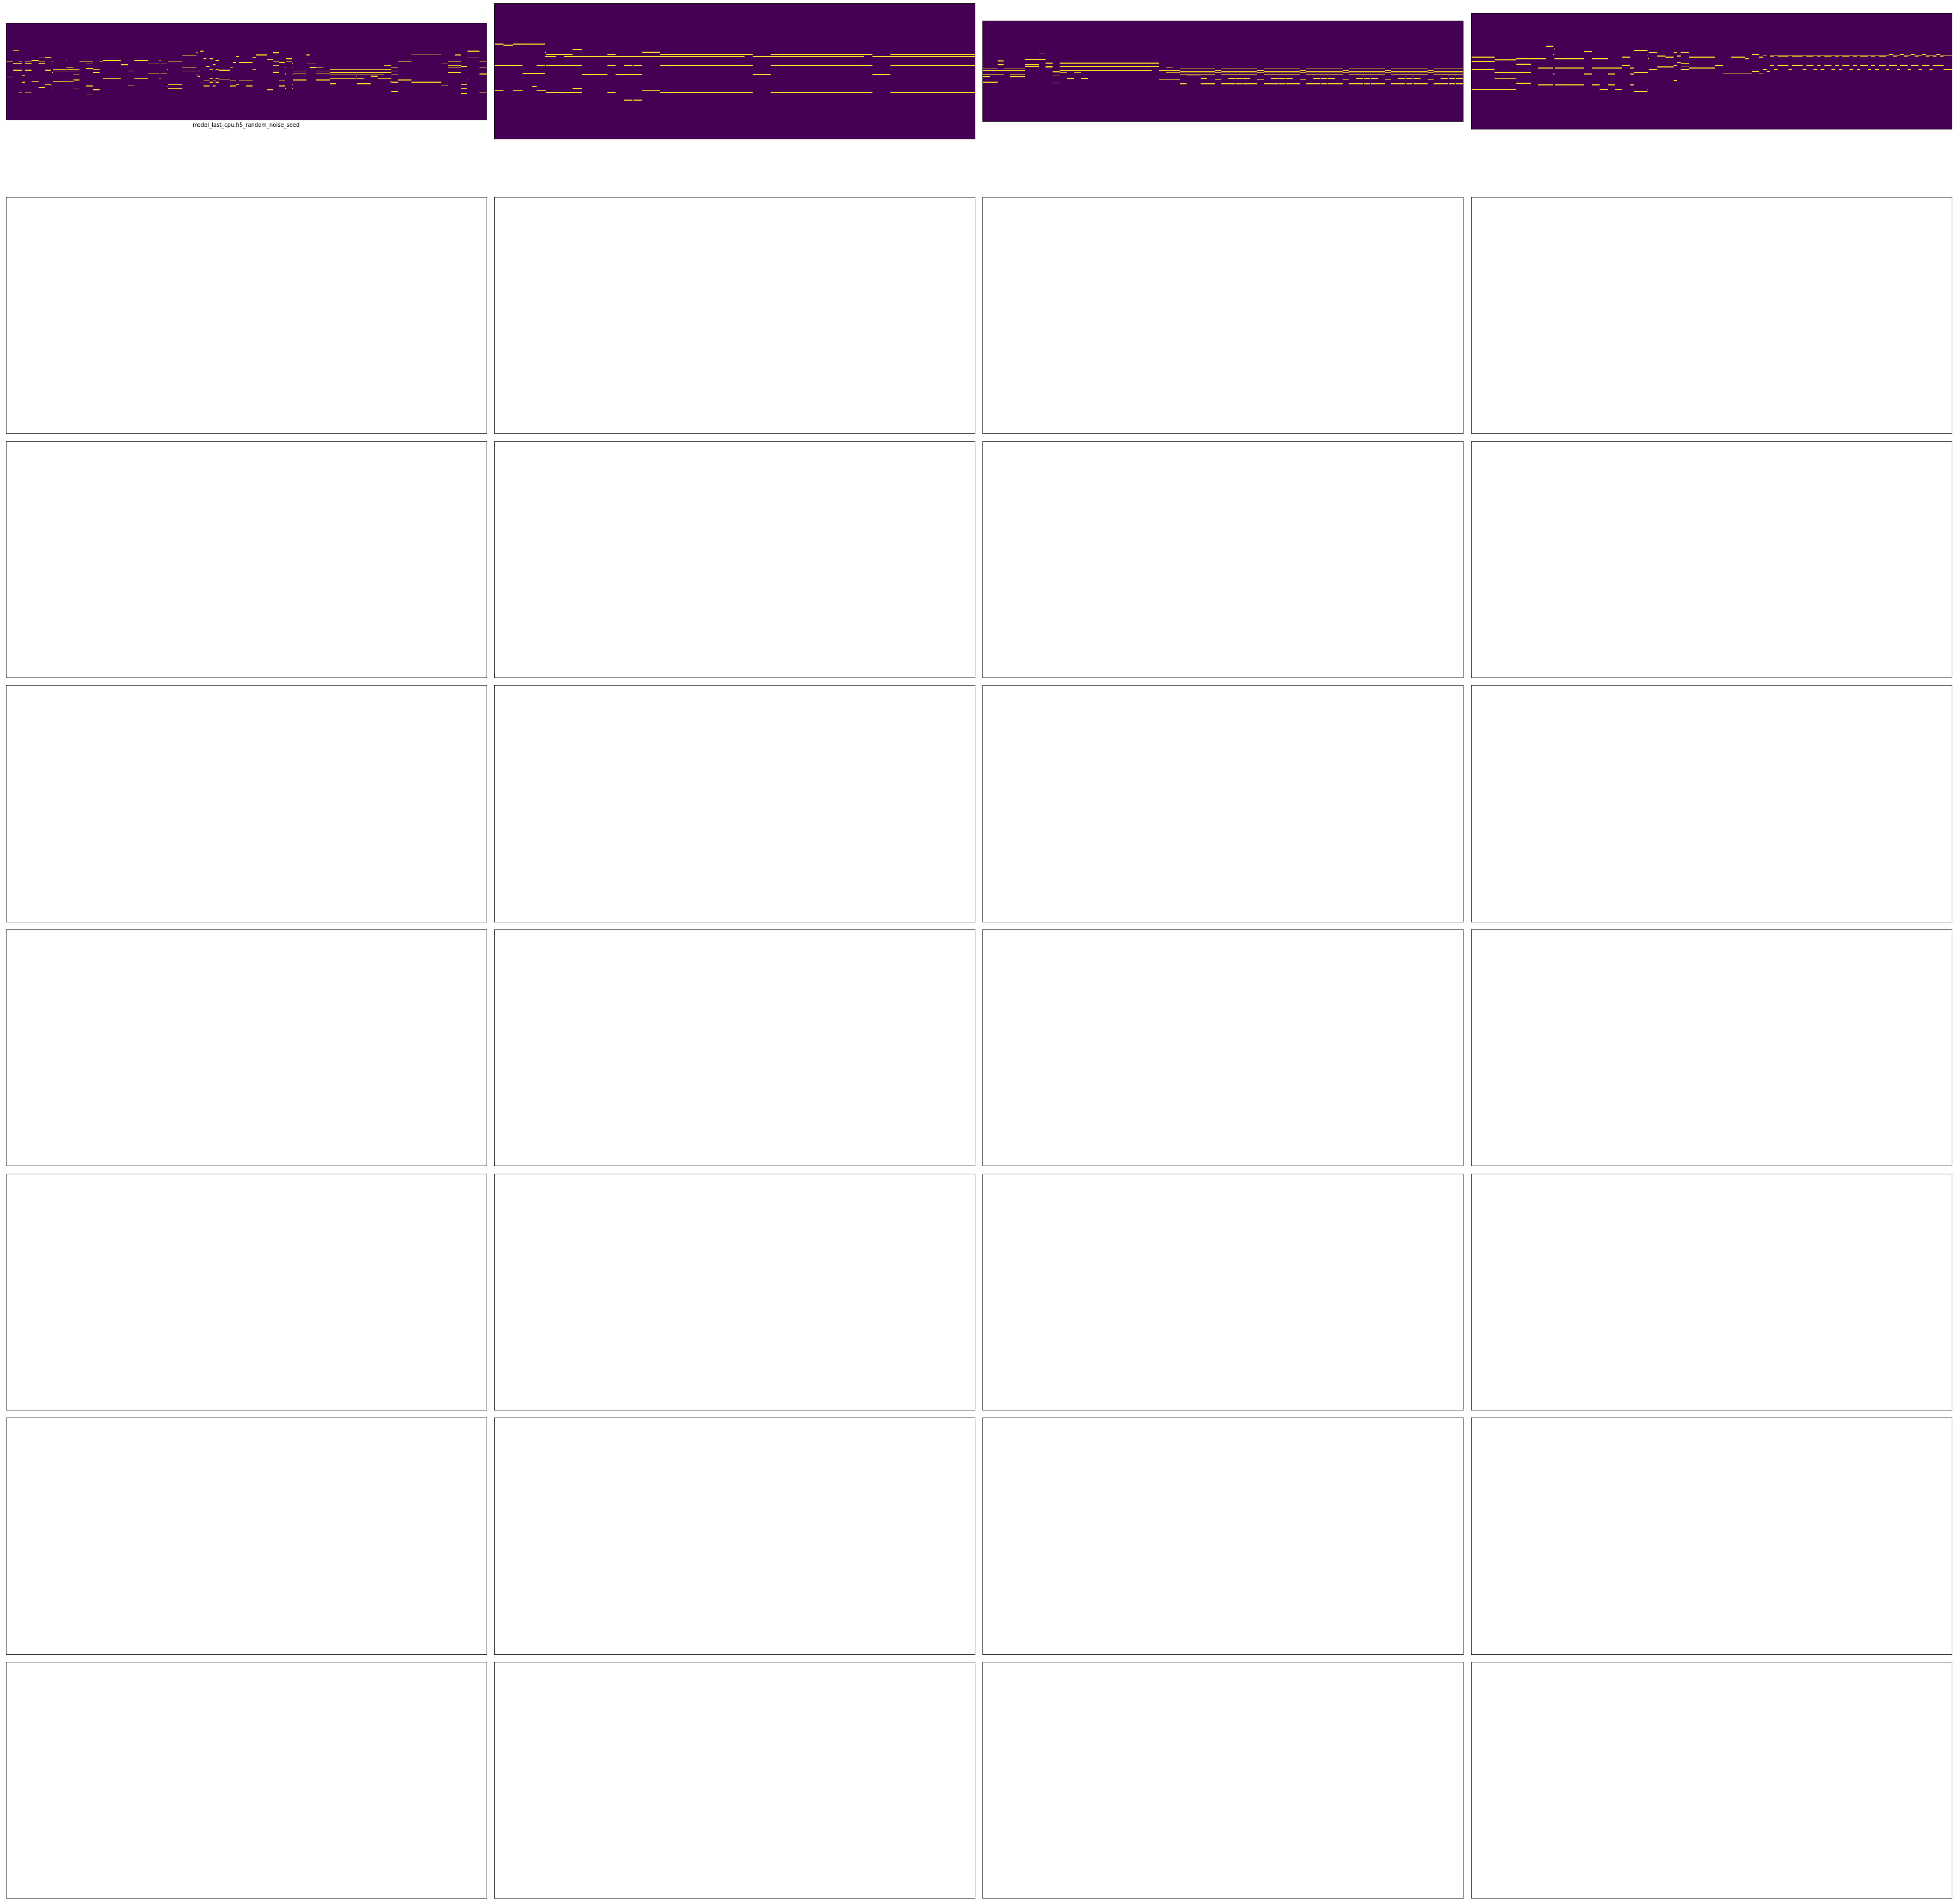

In [113]:
threshold = 0.5

gen_time = datetime.now().isoformat().split('.')[0]

_, axs = plt.subplots(nrows=len(seed_gens), ncols=BATCH_SIZE, figsize=(50, 50),
                          subplot_kw={'xticks': [], 'yticks': []})

for j, ((gen_name, _), sparse_samples) in enumerate(zip(seed_gens, sparse_samples_per_gen)):
    axs.flat[j * BATCH_SIZE].set(xlabel=f'{model_file}_{gen_name}')

    for i, sample in enumerate(sparse_samples):
        name = f'{model_file}_{gen_name}_{gen_time}_{i}'
        axs.flat[j * BATCH_SIZE + i].imshow(np.where(sample.T[::-1, :] > threshold, 1, 0))

plt.tight_layout()
fig = plt.gcf()

In [64]:
output_dir_ = os.path.join(output_dir, gen_time)
os.makedirs(output_dir_, exist_ok=True)

In [65]:
plot_name = f'{model_file}_{gen_time}'
fig.savefig(os.path.join(output_dir_, f'{plot_name}.png'), dpi=fig.dpi)

In [66]:
for (gen_name, _), midis in zip(seed_gens, midis_per_gen):
    for i, mid in enumerate(midis):
        name = f'{model_file}_{gen_name}_{gen_time}_{i}.mid'
        mid.save(os.path.join(output_dir_, name))

In [54]:
# wv.similar_by_vector(samples_per_gen[0][0][0][:16])
# samples_per_gen[0]

In [114]:
from src.data_processing.embedding_sparse_notes.common import unhash_named_frame

def decode_note_frame(x):
    token = wv.similar_by_vector(x[:INPUT_SIZE], topn=1)[0][0]
    return unhash_named_frame(token) if token != '<TRACK_END>' and token != '<UNKNOWN>' else np.zeros((1, 128))

def decode(sample, wv):
    notes = np.concatenate([decode_note_frame(f[:INPUT_SIZE]) for f in sample], axis=0)
    durations = np.stack([adjust_duration(f[INPUT_SIZE:]) for f in sample])
    
    return np.concatenate((notes, durations), axis=1)

stuff = np.concatenate(samples_per_gen, axis=1)
stuff = np.concatenate(stuff, axis=0)

blob = decode(stuff, wv)
tracks_blob_notes = blob[:, :128]
tracks_blob_durations = blob[:, 128:]
blob.shape, tracks_blob_notes.shape, tracks_blob_durations.shape

((604, 152), (604, 128), (604, 24))

In [115]:
import src.evaluation.sparse_clustered_time.rythm_measurements as rm
import src.evaluation.sparse_clustered_time.tonal_measurements as tm

print('tonal measurements')
print(f'tonal range:       {tm.tonal_range(tracks_blob_notes)}')
print(f'tonal compression: {tm.tonal_compression(tracks_blob_notes)}')
print('\nrythm measurements')
print(f'rythm range:       {rm.rythm_range(tracks_blob_durations)}')
print(f'rythm compression: {rm.rythm_compression(tracks_blob_durations)}')

tonal measurements
tonal range:       61
tonal compression: 6.562293274531422

rythm measurements
rythm range:       23
rythm compression: 7.01010101010101


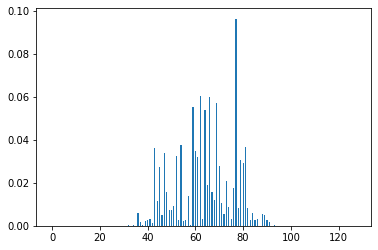

In [116]:
# tonal hist
data = tm.tonal_hist(tracks_blob_notes)

plt.bar(np.arange(0, 128), data, width = 0.5)

# np.save(os.path.join(output_dir_, 'tonal_hist.npy'), data)
# plt.savefig(os.path.join(output_dir_, 'tonal_hist.png'))

plt.show()

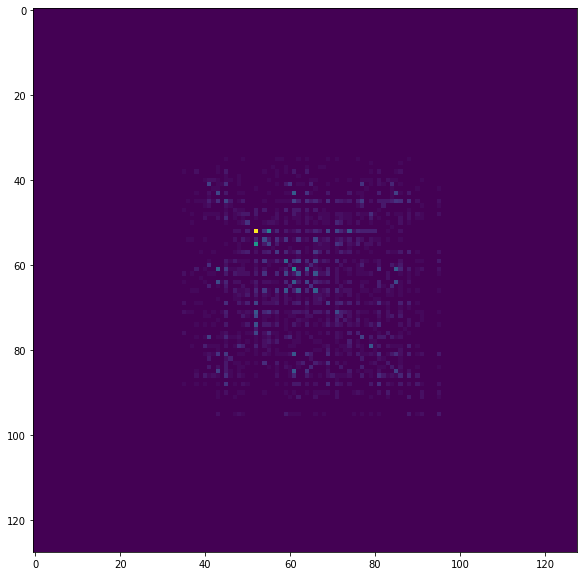

In [108]:
# tonal transition matrix
data = tm.tonal_transition_matrix(tracks_blob_notes)

fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(data, interpolation='none')
# ax1.set_title('larger figure')

# np.save(os.path.join(output_dir_, 'tonal_transition.npy'), data)
# plt.savefig(os.path.join(output_dir_, 'tonal_transition.png'))

plt.show()

(604, 24)


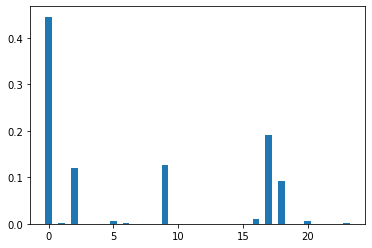

In [117]:
# rythm hist
data = rm.rythm_hist(tracks_blob_durations)
print(tracks_blob_durations.shape)
plt.bar(np.arange(0, 24), data, width = 0.5)

# np.save(os.path.join(output_dir_, 'rythm_hist.npy'), data)
# plt.savefig(os.path.join(output_dir_, 'rythm_hist.png'))

plt.show()

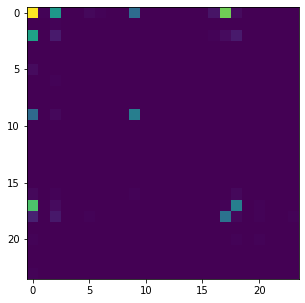

In [118]:
# duration transition matrix
data = rm.rythm_transition_matrix(tracks_blob_durations)

fig = plt.figure(figsize = (5,5)) # create a 5 x 5 figure 
ax1 = fig.add_subplot(111)
ax1.imshow(data, interpolation='none')
# ax1.set_title('larger figure')

# np.save(os.path.join(output_dir_, 'rythm_transition.npy'), data)
# plt.savefig(os.path.join(output_dir_, 'rythm_transition.png'))

plt.show()